In [1]:
'''
This notebook implements a batch run for OFAT analysis
Packages
'''
from model import *
import csv
from mesa.batchrunner import BatchRunner
import pandas as pd
import numpy as np
import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import time
from SALib.sample import saltelli
from SALib.analyze import sobol
from itertools import combinations
from joblib import Parallel, delayed

In [2]:
'''
Initial Conditions as given in notebook
'''
initial_houses = 20
initial_households = 30
rental_cost = 1000
savings_lower = 0
savings_upper = 50_000
price_lower = 10_000
price_upper = 100_000
columns = ('Variable', 'Parameter', 'Gini')

'''
This defines model run
'''
samples = 10
max_steps = 2
ofat_size = 5

In [3]:
'''
This defines the bounds of for the ofat analysis
'''
problem = {
    'names': ['savings_lower', 'savings_upper', 'price_lower', 'price_upper', 'rental_cost'],
    'bounds': [[1, 40_000], [1, 100_000], [10_000, 90_000], [11_000, 100_000], [1000, 20_000]]    
}

In [4]:
def collect_samples(samples, columns, parameter, values):
    df_experiment = pd.DataFrame(columns=columns)
    parameter_name = parameter
    
    for k in range(int(samples)):
        '''
        Repeat trial with certain parameter k times to apply clt
        '''            
        model = HousingMarket(parameter := values)
        model.run_model(max_steps)
        data = model.datacollector.get_model_vars_dataframe()
        dic = {'Variable': parameter_name, 'Parameter': parameter, 'Gini': data['Gini'].iloc[-1]}
        df_experiment = pd.concat([df_experiment, pd.DataFrame(pd.Series(dic)).T])
    return df_experiment

In [5]:
def run_batch_parallel(problem, i, ofat_size, samples, columns):
    parameter = problem['names'][i]
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    #df_experiment = pd.DataFrame(columns = columns)
    results = Parallel(n_jobs=8)(delayed(collect_samples)(samples, columns, parameter, int(value))
                       for value in variable_values)
    final = pd.concat(results)
    return final

In [6]:
results = run_batch_parallel(problem, 0, ofat_size, samples, columns)

In [8]:
def run_batch(problem, i, ofat_size):
    parameter = problem['names'][i]
    parameter_name = parameter
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    df_experiment = pd.DataFrame(columns = ('Variable', 'Parameter', 'Gini'))
    
    for j in variable_values:
        '''
        Iterate over bounds of paramter
        '''
                    
        for k in range(samples):
            '''
            Repeat trial with certain parameter k times to apply clt
            '''            
            model = HousingMarket(parameter := int(j))
            model.run_model(max_steps)
            data = model.datacollector.get_model_vars_dataframe()
            dic = {'Variable': parameter_name, 'Parameter': j, 'Gini': data['Gini'].iloc[-1]}
            df_experiment = pd.concat([df_experiment, pd.DataFrame(pd.Series(dic)).T])
        
    return df_experiment

In [9]:
results = Parallel(n_jobs=8)(delayed(run_batch)(problem, i, ofat_size)
                             for i in range(len(problem['names'])))

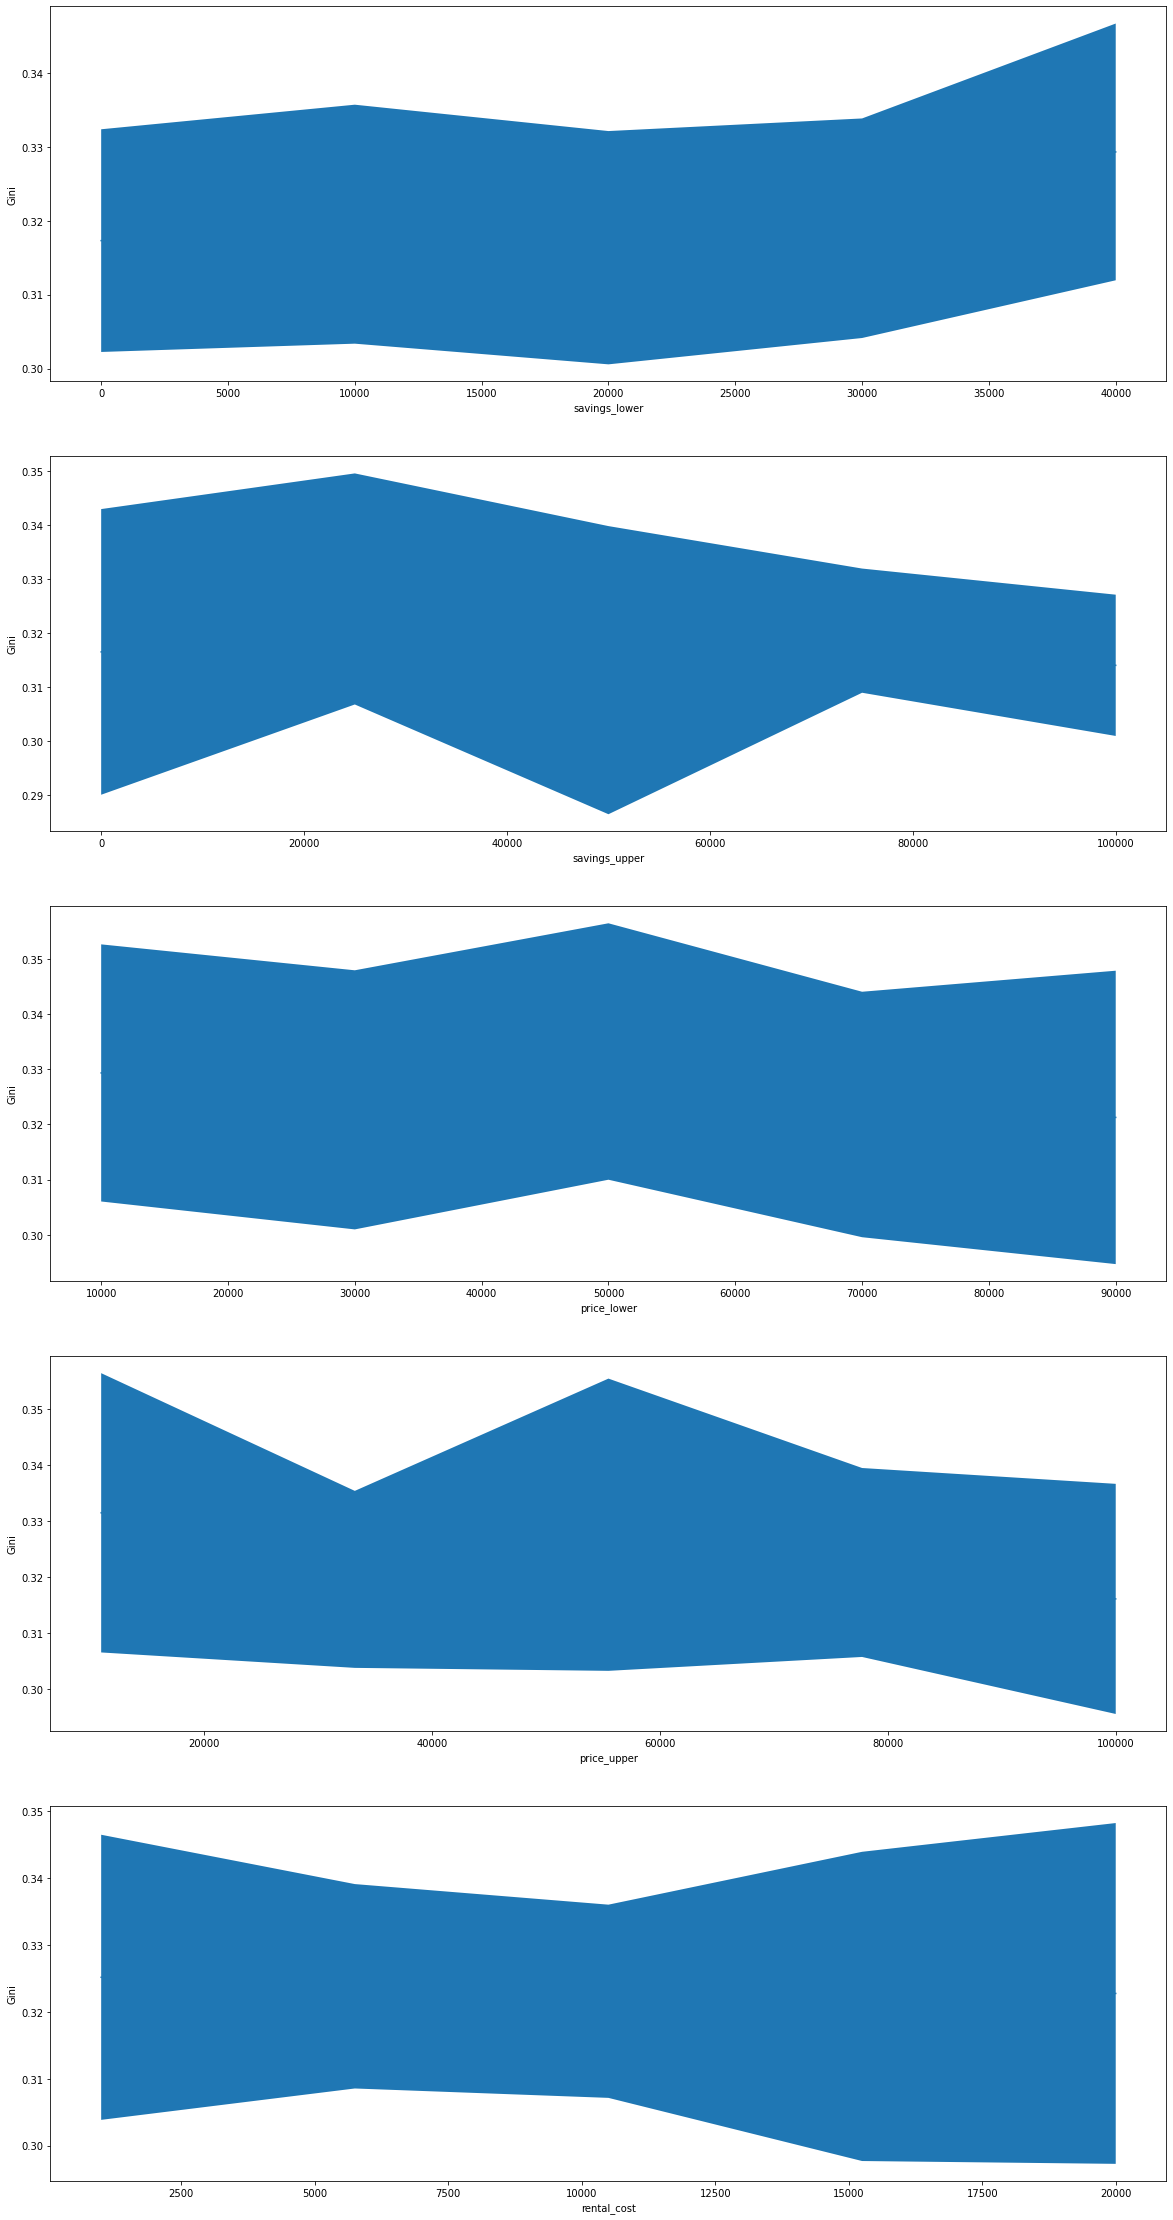

In [10]:
fig, axs = plt.subplots(len(problem['names']), figsize = (20,40))


for i, result in enumerate(results):
    y = []
    err = []
    x = np.linspace(*problem['bounds'][i], ofat_size)
    for j in range(len(x)):
        series = result[int(j*samples):int((j+1)*samples)]
        y.append(series['Gini'].mean())
        err.append(series['Gini'].std())
        
    axs[i].plot(x, y)
    axs[i].fill_between(x, np.array(y) - np.array(err), np.array(y) + np.array(err)) 
    axs[i].set_ylabel("Gini")
    axs[i].set_xlabel(result.iloc[[0]]["Variable"][0])

## Global Sensitivy Analysis

In [ ]:
'''
This section runs Sobol
'''


problem = {
    'num_vars': 3,
    'names': ['price_lower', 'price_upper', 'rental_cost'],
    'bounds': [[10_000, 20_000], [21_000, 100_000], [1000, 20_000]]    
}

In [ ]:
replicates = 10
max_steps = 50
distinct_samples = 10

In [ ]:
'''
Generate Saltetlli sample
'''
param_values = saltelli.sample(problem, distinct_samples)

In [ ]:
counter = 0
df_global = pd.DataFrame(columns = ('Price_lower', 'Price_higher', 'Rental_cost', 'Run', 'Gini'))

for i in range(replicates):
    for vals in param_values:       
        model = HousingMarket(price_lower = int(vals[0]), price_upper = int(vals[1]), rental_cost = int(vals[2]))
        model.run_model(max_steps)
        data = model.datacollector.get_model_vars_dataframe()
        dict = {'Price_lower': vals[0], 'Price_higher': vals[1],
                'Rental_cost': vals[2], 'Run': counter, 'Gini': data['Gini'].iloc[-1]}
        df_global = df_global.append(dict, ignore_index=True)
        counter += 1

In [ ]:
df_global

In [ ]:
sobal_gini = sobol.analyze(problem, df_global['Gini'].values, print_to_console = True )

In [ ]:
'''
Code from notebook
'''

def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

In [ ]:
problem['names']

In [ ]:
# First order
plot_index(sobal_gini, problem['names'], '1', 'First order sensitivity')
plt.show()

# Second order
plot_index(sobal_gini, problem['names'], '2', 'Second order sensitivity')
plt.show()

# Total order
plot_index(sobal_gini, problem['names'], 'T', 'Total order sensitivity')
plt.show()